In [1]:
import _base_path
import pickle
import torch
import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm 
from transformers import AutoTokenizer

import matplotlib
if 'init_done' in globals():
    matplotlib.use("pgf")
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })
import matplotlib.pyplot as plt

from resources.evaluator import EvaluatorConformalSimple, EvaluatorMaxK
from resources.models import DummyModel
from resources.data_io import load_mappings, load_data

from TrainerClassic import TrainerClassic
from TrainerTransformer import TrainerTransformer

init_done = True

C:\Users\Korbi\AppData\Local\Temp\ipykernel_12340\4216375363.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
DATA     = 'incidents'
TEXTS    = 'title'
LABEL    = 'product'

K        = list(np.arange(1901) + 1)
EPSILON  = list(np.power(2, np.arange(0, 6, .2)) / 100.)

In [3]:
mappings = load_mappings(f"../data/{DATA}/splits/", LABEL)
mappings

array(['adobo seasoning', 'after dinner mints', 'alcoholic beverages',
       ...,
       'yoghurt-like soya-based products containing bacteria cultures',
       'yogurt raisins', 'zomi and palm oil'], dtype='<U70')

# Predict sets:

In [4]:
def predict(load_base_classifier):
    ps_max_k = [pd.DataFrame() for _ in range(5)]
    ps_conf  = [pd.DataFrame() for _ in range(5)]
 
    for i in range(5):
        # load evaluators
        evaluator_base, tokenizer = load_base_classifier(i)
        evaluator_maxk = EvaluatorMaxK(evaluator_base)
        evaluator_conf = EvaluatorConformalSimple(evaluator_base)

        # load data:
        _, data_calib, data_test = load_data(
            f"../data/{DATA}/splits/",
            TEXTS,
            LABEL,
            i,
            tokenizer,
            add_texts=True
        )

        # predict class probabilities:
        probs = evaluator_base.predict(data_test)

        ps_max_k[i]['texts']  = evaluator_base.last_texts
        ps_max_k[i]['labels'] = list(probs['labels'])
        
        ps_conf[i]['texts']  = evaluator_base.last_texts
        ps_conf[i]['labels'] = list(probs['labels'])

        # calibrate conformal prediction:
        evaluator_conf.calibrate(data_calib)

        # predict sets:
        for epsilon in EPSILON:
            ps_conf[i][f'{epsilon:.2f}'] = evaluator_conf.predict(epsilon, y_pred=probs['predictions'])['predictions']

        # predict max-k sets:
        for k in K:
            ps_max_k[i][f'{k:d}'] = evaluator_maxk.predict(k, y_pred=probs['predictions'])['predictions']

    return ps_max_k, ps_conf

In [5]:
def evaluate(ps, keys):
    sl, sa = {}, {}

    for key in keys:
        sl[key] = [len(y_pred) for df in ps for y_pred in df[key].values]
        sa[key] = [np.mean([np.argmax(y_true) in y_pred['i'] for y_true, y_pred in df[['labels', key]].values]) for df in ps]

    return sl, sa

## Best traditional classifier:

In [ ]:
ps_classic_max_k, ps_classic_conf = predict(
    lambda i: TrainerClassic.load(f'../models/bow-svm/bow-svm-{LABEL}-{i:d}/', 'sum', 2)
)

In [ ]:
ps_deep_max_k, ps_deep_conf = predict(
    lambda i: (
        TrainerTransformer.load(
            dir=f'../models/roberta-base/roberta-base-{LABEL}-{i:d}/f1/',
            batch_size=16,
            expand_fcn=lambda labels, predictions: (
                labels.type(torch.float),
                predictions['logits']
            ),
            loss_fcn=torch.nn.CrossEntropyLoss(
                #weight=None,
                reduction='mean'
            ),
            num_labels=len(mappings),
            normalize_fcn='sum'
        ),
        AutoTokenizer.from_pretrained('roberta-base')
    )
)

# Best traditional classifier:

## max-$k$ prediction:

In [ ]:
# evaluate set length and accuracy:
sl_classic_max_k, sa_classic_max_k = evaluate(ps_classic_max_k, [f'{k:d}' for k in K])

In [ ]:
# print best:
k = '5'
print(f'Set length: ${np.mean(sl_classic_max_k[k]):.2f} \\pm {np.std(sl_classic_max_k[k]):.2f}$')
print(f'    -> max: ${np.max(sl_classic_max_k[k]):.2f}$')
print(f'    -> min: ${np.min(sl_classic_max_k[k]):.2f}$')
print()
print(f'Set accuracy: ${np.mean(sa_classic_max_k[k]):.2f} \\pm {np.std(sa_classic_max_k[k]):.2f}$')
print(f'      -> max: ${np.max(sa_classic_max_k[k]):.2f}$')
print(f'      -> min: ${np.min(sa_classic_max_k[k]):.2f}$')

Set length: $5.00 \pm 0.00$
    -> max: $5.00$
    -> min: $5.00$

Set accuracy: $0.90 \pm 0.01$
      -> max: $0.91$
      -> min: $0.90$


## Conformal prediction:

In [ ]:
# evaluate set length and accuracy:
sl_classic_conf, sa_classic_conf = evaluate(ps_classic_conf, [f'{epsilon:.2f}' for epsilon in EPSILON])

In [ ]:
# print best:
epsilon = '0.01'
print(f'Set length: ${np.mean(sl_classic_conf[epsilon]):.2f} \\pm {np.std(sl_classic_conf[epsilon]):.2f}$')
print(f'    -> max: ${np.max(sl_classic_conf[epsilon]):.2f}$')
print(f'    -> min: ${np.min(sl_classic_conf[epsilon]):.2f}$')
print()
print(f'Set accuracy: ${np.mean(sa_classic_conf[epsilon]):.2f} \\pm {np.std(sa_classic_conf[epsilon]):.2f}$')
print(f'      -> max: ${np.max(sa_classic_conf[epsilon]):.2f}$')
print(f'      -> min: ${np.min(sa_classic_conf[epsilon]):.2f}$')

Set length: $16.26 \pm 4.63$
    -> max: $28.00$
    -> min: $2.00$

Set accuracy: $0.99 \pm 0.01$
      -> max: $1.00$
      -> min: $0.98$


# Best transformer:

## max-$k$ prediction:

In [ ]:
# evaluate set length and accuracy:
sl_deep_max_k, sa_deep_max_k = evaluate(ps_deep_max_k, [f'{k:d}' for k in K])

In [ ]:
# print best:
k = '5'
print(f'Set length: ${np.mean(sl_deep_max_k[k]):.2f} \\pm {np.std(sl_deep_max_k[k]):.2f}$')
print(f'    -> max: ${np.max(sl_deep_max_k[k]):.2f}$')
print(f'    -> min: ${np.min(sl_deep_max_k[k]):.2f}$')
print()
print(f'Set accuracy: ${np.mean(sa_deep_max_k[k]):.2f} \\pm {np.std(sa_deep_max_k[k]):.2f}$')
print(f'      -> max: ${np.max(sa_deep_max_k[k]):.2f}$')
print(f'      -> min: ${np.min(sa_deep_max_k[k]):.2f}$')

Set length: $5.00 \pm 0.00$
    -> max: $5.00$
    -> min: $5.00$

Set accuracy: $0.91 \pm 0.00$
      -> max: $0.91$
      -> min: $0.90$


## Conformal prediction:

In [ ]:
# evaluate set length and accuracy:
sl_deep_conf, sa_deep_conf = evaluate(ps_deep_conf, [f'{epsilon:.2f}' for epsilon in EPSILON])

In [ ]:
# print best:
epsilon = '0.01'
print(f'Set length: ${np.mean(sl_deep_conf[epsilon]):.2f} \\pm {np.std(sl_deep_conf[epsilon]):.2f}$')
print(f'    -> max: ${np.max(sl_deep_conf[epsilon]):.2f}$')
print(f'    -> min: ${np.min(sl_deep_conf[epsilon]):.2f}$')
print()
print(f'Set accuracy: ${np.mean(sa_deep_conf[epsilon]):.2f} \\pm {np.std(sa_deep_conf[epsilon]):.2f}$')
print(f'      -> max: ${np.max(sa_deep_conf[epsilon]):.2f}$')
print(f'      -> min: ${np.min(sa_deep_conf[epsilon]):.2f}$')

Set length: $21.73 \pm 4.34$
    -> max: $29.00$
    -> min: $9.00$

Set accuracy: $0.99 \pm 0.00$
      -> max: $0.99$
      -> min: $0.99$


# Plots:

In [ ]:
def boxplot(**kwargs):
    data   = []
    labels = []
    for param in kwargs:
        for value in kwargs[param]:
            data.append(kwargs[param][value])
            labels.append(f'${param}={value}$')

    plt.boxplot(np.transpose(np.array(data)), labels=labels)

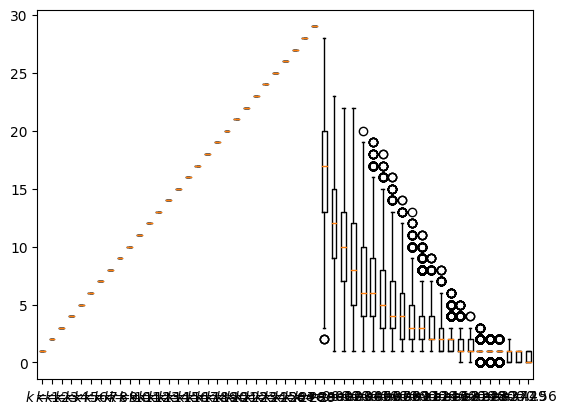

In [ ]:
boxplot(k=sl_classic_max_k, e=sl_classic_conf)

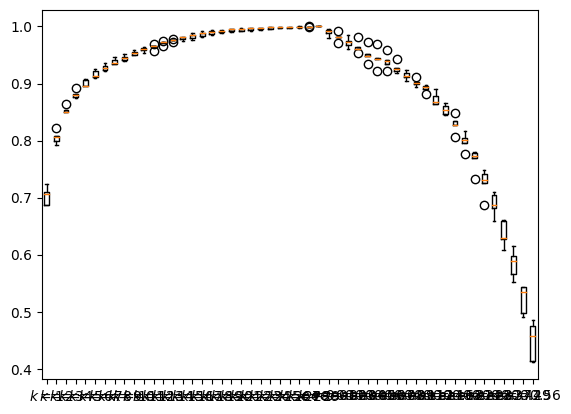

In [ ]:
boxplot(k=sa_classic_max_k, e=sa_classic_conf)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

clf_classic = 'BOW-SVM'
clf_deep = 'RoBERTa'
left = (LABEL == 'hazard_category')

# plot curve for conformal with best traditional cf:
data_x_classic_conf = []
data_y_classic_conf = []
try:
    for epsilon in sl_classic_conf:
        data_x_classic_conf.append(np.mean(sl_classic_conf[epsilon]))
        data_y_classic_conf.append(np.mean(sa_classic_conf[epsilon]))
    ax.plot(data_x_classic_conf, data_y_classic_conf, label=f'{clf_classic} + conformal')
except NameError: pass

# plot curve for max-k with best traditional cf:
data_x_classic_max_k = []
data_y_classic_max_k = []
try:
    for k in sl_classic_max_k:
        data_x_classic_max_k.append(np.mean(sl_classic_max_k[k]))
        data_y_classic_max_k.append(np.mean(sa_classic_max_k[k]))
    ax.plot(data_x_classic_max_k, data_y_classic_max_k, label=f'{clf_classic} + max-$k$')
except NameError: pass

# plot curve for conformal with best transformer cf:
data_x_deep_conf = []
data_y_deep_conf = []
try:
    for epsilon in sl_deep_conf:
        data_x_deep_conf.append(np.mean(sl_deep_conf[epsilon]))
        data_y_deep_conf.append(np.mean(sa_deep_conf[epsilon]))
    ax.plot(data_x_deep_conf, data_y_deep_conf, label=f'{clf_deep} + conformal')
except NameError: pass

# plot curve for max-k with best transformer cf:
data_x_deep_max_k = []
data_y_deep_max_k = []
try:
    for k in sl_deep_max_k:
        data_x_deep_max_k.append(np.mean(sl_deep_max_k[k]))
        data_y_deep_max_k.append(np.mean(sa_deep_max_k[k]))
    ax.plot(data_x_deep_max_k, data_y_deep_max_k, label=f'{clf_deep} + max-$k$')
except NameError: pass

# plot extreme values:
x_max = max([max(data_x_classic_max_k), max(data_x_classic_conf)])
ax.plot([1., 1., x_max], [.5, 1., 1.], 'r--')
ax.plot(1., 1., 'or--', label='optimum')

# plot base performance:
try:
    y_min_classic = np.mean(sa_classic_max_k['1'])
    ax.plot([1., x_max], [y_min_classic, y_min_classic], 'g--')
    ax.plot(1, y_min_classic, 'og--', label=clf_classic)
except NameError: pass

try:
    y_min_deep = np.mean(sa_deep_max_k['1'])
    ax.plot([1., x_max], [y_min_deep, y_min_deep], 'b--')
    ax.plot(1, y_min_deep, 'ob--', label=clf_deep)
except NameError: pass

margin = (x_max-1.) * 0.02
ax.set_xlim(1 - margin, x_max + margin)

margin = 0.5 * 0.02
ax.set_ylim(0.5 - margin, 1 + margin)

for y in [.5, .6, .7, .8 , .9, 1.]:
    ax.axhline(y, linewidth=.5, color='grey', zorder=0)

ax.set_title(f'\\texttt\u007B{LABEL}\u007D')
ax.set_xlabel('Average Set Length')
if left:
    ax.set_yticks([.5, .6, .7, .8 , .9, 1.])
    ax.set_ylabel('Average Set Accuracy')
    ax.legend(fontsize=8)

else:
    ax.set_yticks([])
    ax.set_ylabel('')

plt.subplots_adjust(bottom=0.15, left=0.2, right=.95, top=.9)
plt.savefig(f'plots/conformal_performance_{LABEL}.pdf')
plt.show()

C:\Users\Korbi\AppData\Local\Temp\ipykernel_13680\2779057370.py:87: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()
